# Demodulate an OFDM Signal

In this problem, you will be given samples of an OFDM signal. That signal contains messages for $N=10$ users. 

Your task is to recover the message that is intended for you (where you will be identified by a user id that consists of the last two digits of your GMU ID). The following user ids are used to construct the signal:
``` python
user_ids = [87, 67, 6, 66, 32, 90, 25, 71, 13, 21]
```
One of them should correspond to the last two (or one if the first is zero) digits of your GMU id. If you can't find your user id, just pick any of them.

The format of the OFDM signal will be described in detail below with illustrations/clarifications in Python code. 

The signal is transmitted over a (simulated) channel that is also described below.

In [1]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np

import struct # for header
from typing import Tuple

# To plot pretty figures, use matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Functions from other notebooks

Before describing the OFDM signal, 
hera are a few functions copied from other notebooks. These are either used to construct the signal or are likely useful in receiving the signal.

In [2]:
def crc16(data: bytes, poly=0x8408):
    """
    CRC-16-CCITT Algorithm

    Args:
        data (bytes): byte sequence to be checked (type bytes)
        poly (int): 16-bit integer indicating the polynomial used by CRC (default 0x8408)

    Returns:
        16-bit CRC
    """
    data = bytearray(data)
    crc = 0xFFFF
    for b in data:
        cur_byte = 0xFF & b
        for _ in range(0, 8):
            if (crc & 0x0001) ^ (cur_byte & 0x0001):
                crc = (crc >> 1) ^ poly
            else:
                crc >>= 1
            cur_byte >>= 1
    crc = ~crc & 0xFFFF
    crc = (crc << 8) | ((crc >> 8) & 0xFF)

    return crc & 0xFFFF


In [3]:
def pop_count32(x: np.uint32) -> np.uint8:
    """count the number of 1s in 32-bit integer x using Wegner's method
    
    Inputs:
    x - a 32 bit integer

    Returns:
    an integer between 0 and 32 indicating the number of 1s in x
    """
    
    count: np.uint8 = 0
    
    while (x > 0):
        x = x & (x-1)
        count += 1
        
    return count

In [4]:
def lfsr_step(state: np.uint32, fb: np.uint32, N: int = 31) -> Tuple[np.uint8, np.uint32]:
    """Single update step of LFSR with feedback connections fb
    
    Inputs:
    * state (uint32): initial state of the feedback shift register
    * fb (uint32): bit map indicating feedback connections; the LSB corresponds to bit 0 in the LFSR
    * N (int) order if the LFSR; must be less than 32 (default: 31)
    
    Returns:
    * elem - next element of the LFSR sequence
    * state - updated state
    
    Example: Generate the first 10 elements of a LFSR sequence with fb=0b1001 and initial state=0b1111
    >>> state = 0b1111
    >>> seq = np.empty(10, dtype=np.uint8)
    >>> for n in range(10):
    >>>     seq[n], state = lfsr31_step(state, 0b1001)
    >>> seq
    
    array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0], dtype=uint8)
    """
    
    # save the LSB before updating state; it will be returned
    elem: np.uint8 = state & 0b1
        
    # update state
    fb_vec: np.uint32 = state & fb
    fb_bit: np.uint8 = (pop_count32(fb_vec) & 0b1)
    
    # insert feedback bit at position N, then shift
    state = (state | fb_bit << N) >> 1
    
    return elem, state

In [5]:
def lfsr(init: np.uint32, fb: np.uint32, M: int, N: int = 31, Nc:int = 0):
    """Compute M samples of a LFSR sequence
    
    Inputs:
    init - initial state of the LFSR
    fb - feedback connection for the LFSR
    M - number of samples to generate
    N - order of the LFSR (default: 31)
    Nc - statrting sample (default 0)

    Returns:
    length-M vector of bits (stored as np.uint8)
    """
    seq = np.empty(M, dtype=np.uint8)

    state = init

    for n in range(Nc):
        _, state = lfsr_step(state, fb, N)          # discard the first Nc

    for n in range(M):  
        seq[n], state = lfsr_step(state, fb, N)     # keep the next Mc

    return seq

In [6]:
def MPE_decision_rule(Z, A):
    """Decide which symbol was most likely transmitted
    
    This function examines matched filter outputs (in vector Z) and for each element of Z selects the symbol 
    from constellation A that is closest.

    Inputs:
    Z - Vector of matched filter outputs
    A - Constellation

    Returns:
    Numpy array of the same length as Z
    """
    ind = np.empty_like(Z, dtype=np.uint8)

    for n in range(len(Z)):
        this_Z = Z[n]
        ind[n] = np.argmin(np.abs(A-this_Z))
        # dec[n] = A[ind]

    return ind

In [7]:
def bytes_to_symbols(msg, bps):
    """Convert a sequence of bytes to symbols
    
    Inputs:
    msg - a vector of bytes
    bps - bits per symbol
    
    Returns:
    vector of ints (all ints are between 0 and 2**bps - 1)
    
    Note: only works for bps in [1, 2, 4]
    """
    
    syms_per_byte = 8 // bps
    mask = np.uint8(2**bps - 1)
    
    out = np.zeros(syms_per_byte * len(msg), dtype=np.uint8)

    for n in range(len(msg)):
        b = msg[n]
        for m in range(syms_per_byte):
            out[n*syms_per_byte + m] = (b >> (m*bps)) & mask
            
    return out

In [8]:
def symbols_to_bytes(syms, bps):
    """Convert a sequence of symbols to bytes
    
    Inputs:
    syms - a vector of bytes
    bps - bits per symbol
    
    Returns:
    vector of uint8 (aka char)
    
    Note: only works for bps in [1, 2, 4]
    """
    syms_per_byte = 8 // bps
    
    msg = np.zeros(len(syms) // syms_per_byte, dtype=np.uint8)
    
    for n in range(len(msg)):
        for m in range(syms_per_byte):
            msg[n] += syms[n*syms_per_byte + m] << (m*bps)
            
    return msg

In [9]:
def bytes_to_img(seq):
    """Interpret the recovered message and display image
    
    Inputs:
    """
    FORMAT = '!HH'
    s = struct.calcsize(FORMAT)

    h, w = struct.unpack(FORMAT, seq[:s])

    plt.imshow(seq[s:].reshape(h,w), cmap='gray')

### Description of the OFDM Signal

The OFDM signal is made up of a sequence of slots, where each slot contains 14 OFDM symbols. 

Each slot contains three distinct elements:
1. Symbol 0 always contains a known synchronization reference signal
2. Symbol 1 always contains dedicated control information (DCI) for each user; this control information is needed to locate the payload within the remainder of the slot
3. The remaining 12 slots contain users' payload. The payload is located within the slot as indicated by the control information.

Note: The location of the DCI and the payload for a user will vary from slot-to-slot. Hence, in each slot, you must first find and decode the DCI and then locate and demodulate the payload.

### OFDM parameters

We define a signalling format that is meant to resemble the downlink of  LTE and 5G NR formats. It is characterized by
* Subcarrier spacing is 15KHz
* FFT size is 2048
* Only 1272 of the subcarriers are occupied; active subcarriers are numbered from $k=0$ to $k=1271$.
* The Cyclic Prefix is 160 samples long; that corresponds to $\frac{160}{2048} \cdot \frac{1}{15\text{KHz}} = 5.2\mu s$.

Information is transmitted in slots that contain 14 OFDM symbols; the length of a slot is just under 1ms. In ach slot, information for $N=10$ users is transmitted as detailed further below.

The first OFDM symbol in each slot contains a known synchronization reference signal. This signal occupies 127 subcarriers in the center of the active subcarriers (i.e., from $k=573$ to $k=699$).

The second symbol contains control information (DCI) from which each user can determine where to find his payload within the slot.

The remaining 12 OFDM symbols carry the users' payloads. The payload for each user occupies a rectangular region in the time-frequency space defined by the slot. The location where a user's payload is found changes from slot to slot; it is described by the DCI information transmitted in the second symbol.

Subcarriers that carry a DCI block or a user's payload are divided into blocks of 12 subcarriers. Put differently, the frequency part of the rectangular regions begins and ends on subcarriers with indices that are divisible by 12.


In [10]:
## OFDM Parameters
sc_spacing = 15e3
N_FFT = 2048
N_active = 1272
N_syms = 14
N_CP = 160

Fs = sc_spacing * N_FFT

# number of subcarriers per SC block
sc_per_scb = 12


### DMRS signals

 The DMRS training sequences are intended to provide initialization for the frequency domain equalizer. We will use Gold sequences that were derived from a pair of M-sequences of order 31. 

 The DMRS sequences are initialized by the user's ID, so that the reference sequences are all distinct.

 Reference sequences are always generated to cover all subcarriers. Only the subcarriers in the user's active bandwidth will be transmitted.

 The function below generates the (BPSK modulated) DMRS sequence for all `N_active` subcarriers for a given user id.

 These DMRS sequence are needed in each slot for both the DCI and payload. It's worth to pre-compute and store them.

In [11]:
def make_DMRS(user_id, N_active):
    """Construct the DMRS sequence for given user id
    
    Input:
    user_id - usr id
    N_active - number of active subcarriers

    Returns:
    length N_active sequence of BPSK symbols
    """
    # make a Gold sequence from 2 M-sequences, the second is initialized by user's id
    dmrs = lfsr(1, 9, N_active, 31, 1600) ^ lfsr(user_id, 15, N_active, 31, 1600)
    
    # convert binary to BPSK
    return 2.0*dmrs - 1.0

### Modulation Formats

We will use three different constellations: BPSK, QPSK, and 16-QAM for the payload. DCI and DMRS are always transmitted as BPSK.
For each constellation, we define a dictionary that shows the mapping of bit-patterns to symbols.

For each of the three constellations, we have:
* a dictionary that shows the mapping from bit-patterns to symbols
* an array that list the symbols in the order indicated by the bit-pattern; e.g., the symbol for `0b0000` (decimal 0) is first, followed by the symbol for `0b0001` (decimal 1).
* an integer that is used as a unique code to refere to the constellation.

In [12]:
BPSK_d = {
    0b0: 1.  + 0j,
    0b1: -1. + 0j
}

# normalized alphabet in order
A_BPSK = np.array([BPSK_d[n] for n in range(2)])

BPSK_MOD_CODE = 0

In [13]:
QPSK_d = {
    0b00:  1. + 1.j,
    0b01: -1. + 1.j,
    0b11: -1. - 1.j,
    0b10:  1. - 1j
}

# normalized alphabet in order
A_QPSK = np.array([QPSK_d[n] for n in range(4)])/np.sqrt(2)

QPSK_MOD_CODE = 1

In [14]:
QAM16_d = {
    0b0000: -3. + 3.j,
    0b0100: -1. + 3.j,
    0b1100:  1. + 3.j,
    0b1000:  3. + 3.j,
    0b0001: -3. + 1.j,
    0b0101: -1. + 1.j,
    0b1101:  1. + 1.j,
    0b1001:  3. + 1.j,
    0b0011: -3. - 1.j,
    0b0111: -1. - 1.j,
    0b1111:  1. - 1.j,
    0b1011:  3. - 1.j,
    0b0010: -3. - 3.j,
    0b0110: -1. - 3.j,
    0b1110:  1. - 3.j,
    0b1010:  3. - 3.j,
}

# normalized alphabet in order
avg_symbol_energy = (4*2 + 8*10 + 4*18)/16
A_QAM16 = np.array([QAM16_d[n] for n in range(16)])/np.sqrt(avg_symbol_energy)

QAM16_MOD_CODE = 2

In [15]:
mod_table = {
    'BPSK': {
        'name': 'BPSK',
        'mod_code': BPSK_MOD_CODE,
        'bps': 1,
        'alphabet': A_BPSK,
        'map': BPSK_d,
    },
    'QPSK': {
        'name': 'QPSK',
        'mod_code': QPSK_MOD_CODE,
        'bps': 2,
        'alphabet': A_QPSK,
        'map': QPSK_d,
    },
    'QAM16': {
        'name': '16-QAM',
        'mod_code': QAM16_MOD_CODE,
        'bps': 4,
        'alphabet': A_QAM16,
        'map': QAM16_d,
    }
}

# make an inverse table for looking up names by mod_code
rev_mod_table = {}
for k,v in mod_table.items():
    rev_mod_table[v['mod_code']] = k

# table for looking up bps by mod_code
bps_table = {}
for k,v in rev_mod_table.items():
    bps_table[k] = mod_table[v]['bps']

## Synchronization Signal

The synchronization reference signal is defined in the frequency domain. The rsynchronization signal are chosen from a length 127 M-sequence. Specifically, the M-sequence generated by a linear feedback shift register with initial value $c_{init}=1$ and feedback connections described by $0x3$ is used.

The synchronization signal will be placed starting at active subcarrier 573, so that it is centered in the frequency domain.

In [16]:
## Generate LFSR sequence 
c_init = 1
fb = 3
M = 127
N = 7

# location of synch signal
k_sync = 573

# generate M-sequence and convert to BPSK (0 -> -1, 1 -> 1)
sync_seq = 2.0*lfsr(c_init, fb, M, N) - 1

## DCI Information

Dedicated control channel information (DCI) is transmitted in symbol period 1. It provides information about where user data is located within a slot and how it is modulated. Specifically, it contains the following fields:
* user id - 8 bits
* start symbol - 4 bits: the first symbol that contains user data (actually, this is where the DMRS goes)
* length in symbols - 4 bits: number of consecutive symbols holding user data
* start subcarrier block - 8 bits: multiply this value by 12 to find the first subcarrier holding user data
* length subcarrier block - 8 bits: multiply this number by 12 to find the number of consecutive subcarriers holding user data
* modulation code - 8 bits: code that indicates how user data is modulated (see modulation table)
* sequence number - 8 bits: sequence number modulo 255
* number of bytes - 16 bits: indicates the number of bytes in the payload. It is possible that there are a few empty subcarriers at the end of an allocated block.

The DCI information is protected by a cyclic redundancy check (CRC).

The function below packs the information for one DCI block into a sequence of bytes.

In [17]:
## constants related to DCI
DCI_FORMAT = "!BBBBBBH"
DCI_CRC_FORMAT = "!{:d}sH".format(struct.calcsize(DCI_FORMAT))

DCI_LEN_BYTES = struct.calcsize(DCI_CRC_FORMAT)

In [18]:
## DCI structure
def make_DCI(user_id, sliv_d, mod_code, seq, n_bytes):
    """construct a DCI block
    
    Inputs:
    user_id - uint8
    sliv_d - dictionary with fields start_sym, len_sym, start_scb, len_scb
    mod_code - code indicating the modulation format
    seq - sequence number (modulo 255)
    num_bytes - length of payload, excluding padding
    """
    # combine start_sym and len_sym into a single byte
    sym_sl = (sliv_d['start_sym'] << 4) + sliv_d['len_sym']

    dci = struct.pack(DCI_FORMAT, user_id, sym_sl, sliv_d['start_scb'], sliv_d['len_scb'], mod_code, seq % 256, n_bytes)

    return struct.pack(DCI_CRC_FORMAT, dci, crc16(dci))

And, this function decodes the DCI block to recover the information required to locate the payload.

In [19]:
def decode_DCI(dci_bytes):
    """Decode a DCI block
    
    Input:
    byte sequence that makes up the DCI

    Returns:
    a tuple containing
    * user_id
    * sliv_d dictionary with fields start_sym, len_sym, start_scb, len_scb
    * mod_code - code indicating the modulation format
    * seq - sequence number (modulo 255)
    * num_bytes - length of payload, excluding padding
    * crc_ok - result of CRC check (True means that CRC passed)
    """
    # separate the CRC and check it
    dci, check = struct.unpack(DCI_CRC_FORMAT, dci_bytes)
    crc_ok = check == crc16(dci)

    # unpack the elements of the DCI
    user_id, sym_sl, start_scb, len_scb, mod_code, seq, n_bytes = struct.unpack(DCI_FORMAT, dci)

    # and pack them into the expected formt
    len_sym = sym_sl % (1 << 4)
    start_sym = sym_sl >> 4

    sliv_d = {
        'start_sym': start_sym,
        'len_sym': len_sym,
        'start_scb': start_scb,
        'len_scb': len_scb
    }

    return user_id, sliv_d, mod_code, seq, n_bytes, crc_ok

In [20]:
## constant to capture DCI length (in symbols, including DMRS symbols)
DCI_LEN = (DCI_LEN_BYTES * 8 * 3) // 2

In [21]:
# check that this works
sliv_d = {
    'start_sym': 2,
    'len_sym': 4,
    'start_scb': 0,
    'len_scb': 12
}

hdr = make_DCI(42, sliv_d, 0, 1, 128)
decode_DCI(hdr)

(42,
 {'start_sym': 2, 'len_sym': 4, 'start_scb': 0, 'len_scb': 12},
 0,
 1,
 128,
 True)

### Transmitting DCI Information

DCI information is always transmitted in the second symbol of a slot (symbol 1); immediately following the slot that carries the synchronization signal (see above).

There are $N=10$ DCI groups consisting of 10 subcarrier blocks (i.e., 120 subcarriers); each of these groups carries the DCI for one user. The $n$-th DCI group begins at subcarrier block $10n$ (i.e., with subcarrier `120*n`).

The DCI information for a user may be transmitted in any of the 10 groups and the location changes from slot-to-slot. Thus, all of the groups must be searched until the DCI block for the given user has been found (as indicated by the user id in the DCI information).

Each DCI group contains 120 BPSK symbols: 80 of these symbols come from the DCI information and the remaining 40 are DMRS symbols.

We denote the BPSK modulated DCI data by $d[n]$ with $0\leq n < 80$ and the DMRS sequence by $c[k]$. Moreover, denote the first subcarrier for the give DCI group by $k_0$. Then, the 120 symbols $s[m]$ are constructed by interleaving the DCI symbols $d[n]$ and the DMRS sequence $c[k]$:

* DMRS: if $k_0 + m \mod 3 = 1$, then $s[m] = c[k_0+m]$. Every third symbol is a DMRS symbol, thus, $120/3=40$ DMRS symbols are inserted.
* DCI: The remaining $80$ symbols are filled in order with DCI symbols $d[n]$.

The embedded DMRS symbols are intended to allow channel estimation for the DCI symbols $d[n]$.

The function below constructs the interleaved symbols $s[n]$ from a DMRS sequence and the DCI bytes constructed by function `make_DCI`.

In [22]:
def interleave_DCI(dci, dmrs, k0):
    """interleave DCI symbols and DMRS symbols
    
    Inputs:
    dci - DCI byte sequence (length 80 bytes)
    dmrs - DMRS sequence for the user identified inside the DCI block
    k0 - first subcarrier that will carry this block

    Returns:
    length DCI_LEN sequence of interleaved symbols
    """
    # storage for result
    s = np.ndarray(DCI_LEN, dtype=complex)

    # convert DCI message to BPSK
    d = A_BPSK[bytes_to_symbols(dci, 1)]

    n = 0
    for m in range(DCI_LEN):
        if ((k0+m) % 3) == 1:
            s[m] = dmrs[k0+m]
        else:
            s[m] = d[n]
            n += 1
    
    return s

### Payload

Finally, the payload for each user is transmitted in rectangular region indicated by the information in the DCI block. Specifically, the `sliv_d` dictionary that is returned by function `decode_DCI` has four elements that describe the location of the user's payload within the slot.

The keys of the `sliv_d` dictionary are:

* `'start_sym'`: The OFDM symbol number of the first symbol holding payload data; this OFDM symbol holds the DMRS sequence for adapting the equalizer (see above);
* `'len_sym'`: The number of consecutive OFDM symbols holding payload data;
* `'start_scb'`: The first subcarrier block that holds payload data; 
* `'len_scb'`:  The number of consecutive sub carrier blocks holding payload data.

For example, assume that `sliv_d` is equal to `{'start_sym': 2, 'len_sym': 4, 'start_scb': 0, 'len_scb': 12}`. Then, the payload will occupy subcarriers 0 through 144 (recall that a subcarrier block contains 12 subcarriers). The DMRS sequence will appear in symbol 2 on those subcarriers. Symbols 3, 4, and 5 will hold payload data on those subcarriers. Hence, there is space for $3 \cdot 144 = 432$ information symbols.

The DMRS sequence will occupy all subcarriers in the indicated range on the first indicated OFDM symbol - there are no gaps. If $c[k]$ denotes the DMRS sequence (length `N_active`), then DMRS element $c[k]$ is transmitted on the $k$-th subcarrier.

Payload data is modulated using the modulation format indicated by the DCI block. Note that in each slot only complete (not partial) bytes will be sent. Consequently, it is possible that not all time-frequency resource elements are occupied. This can be deduced from the parameter `num_bytes` in the DCI block.

The function below is used to map information bytes to a rectangular region in time-frequency. This rectangular block is intended to be inserted in the transmitted slot

In [23]:
def make_payload(info_bytes, dmrs, sliv_d, mod_code):
    """Construct a rectangular region holding payload and DMRS
    
    Inputs:
    info_bytes - sequence of information bytes to be sent
    dmrs - DMRS sequence for given user
    sliv_d - dictionary describing time-frequency region
    mod_code - code indicating modulation format

    Returns:
    rectangular time-frequency region with payload and DMRS data
    """
    Nc = sc_per_scb*sliv_d['len_scb'] # number of subcarriers
    Ns = sliv_d['len_sym']            # number of symbols

    # make space to hold rectangular region
    R = np.zeros((Ns, Nc), dtype=complex)

    # insert DMRS - make sure we grab the elements that match the allocated subcarriers!
    R[0, :] = dmrs[sc_per_scb*sliv_d['start_scb'] + np.arange(Nc)]

    # modulate the payload information
    mod = rev_mod_table[mod_code]

    A = mod_table[mod]['alphabet']
    bps = mod_table[mod]['bps']
    syms = A[bytes_to_symbols(info_bytes, bps)]

    # insert the modulated symbols in frequency first order
    start = 0
    for n in range(1, Ns):
        end = min(start+Nc, len(syms))
        R[n, :end-start] = syms[start:end]
        n = end
        start = end

    return R

### Assembling the Pieces

We now have all pieces in place to construct a slot of 14 OFDM symbols. We will illustrate how the slot is assembled by placing a single user's components into the slot. The actual signal is constructed by placing additional users' data in the empty spaces of the slot.

In this illustration, we will assume that:
* the user id is `user_id = 42`
* the DCI block will be placed in the second group of DCI subcarriers, `n_DCI = 1` (i.e., starting at subcarrier 120)
* the data is QPSK modulated (`mod_code = 1`)
* the dictionary indicating the rectangular time-frequency region is as above 
`sliv_d = {'start_sym': 2, 'len_sym': 4, 'start_scb': 0, 'len_scb': 12}`
* the sequence number is `seq = 0`.

With this configuration, we can transmit $3 \cdot 12 \cdot 12 = 432$ symbols (`(sliv_d['len_sym'] - 1) * sliv_d['len_scb'] * sc_per_scb`). As QPSK carries 2 bits per symbol, we can place $2 \cdot 432 = 864$ bits or $\lfloor 864/8 \rfloor = 108$ bytes. We construct an arbitrary payload of 108 bytes.

In [24]:
## parameters
user_id = 42
n_DCI = 1
mod_code = 1
sliv_d = {'start_sym': 2, 'len_sym': 4, 'start_scb': 0, 'len_scb': 12}
seq = 0

# figure out space for payload
mod = rev_mod_table[mod_code]
bps = mod_table[mod]['bps']
num_bytes = ((sliv_d['len_sym'] - 1) * sliv_d['len_scb'] * sc_per_scb * bps) // 8

# make up a payload
pld = np.arange(num_bytes, dtype=np.uint8)

# compute the DMRS sequence for this user
dmrs = make_DMRS(user_id, N_active)

In [25]:
## construct the (active part of) the slot
# Allocate space for a slot
Slot_active = np.zeros((N_syms, N_active), dtype=complex)

# insert the synch signal in symbol 0
Slot_active[0, k_sync:k_sync+len(sync_seq)] = sync_seq

# construct and insert the DCI block in symbol 0
k0 = n_DCI * DCI_LEN   # first subcarrier
dci = make_DCI(user_id, sliv_d, mod_code, seq, num_bytes)
Slot_active[1, k0:k0+DCI_LEN] = interleave_DCI(dci, dmrs, k0)

## construct the rectangular block that holds the payload and insert it
fs = sliv_d['start_sym']
ls = fs + sliv_d['len_sym']
fc = sc_per_scb * sliv_d['start_scb']
lc = fc + sc_per_scb * sliv_d['len_scb']

Slot_active[fs:ls,fc:lc] = make_payload(pld, dmrs, sliv_d, mod_code)

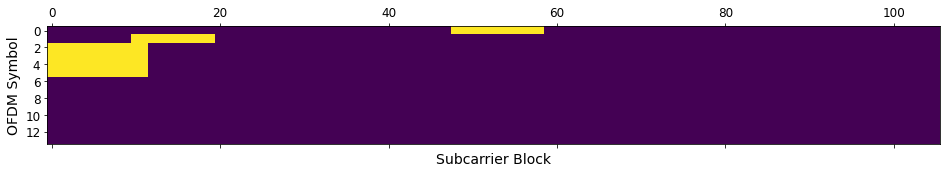

In [26]:
# check that this is as expected
plt.matshow(np.abs(Slot_active[:, ::12]))
plt.xlabel('Subcarrier Block')
plt.ylabel('OFDM Symbol')
plt.show()

## OFDM

The only thing left to do to produce samples that can be transmitted is to perform OFDM, i.e., insertion of guard bands, inverse FFT, insertion of cyclic prefix and parallel-to-serial conversion.

The function below performs all of these steps and produces an array of `N_syms * (N_FFT + N_CP)` (30192) samples.

In [27]:
def OFDM_TX(Slot_active, N_FFT, N_CP):
    """Construct OFDM signal for transmission
    
    Inputs:
    Slot_active - 2D array with data for active subcarrier
    N_FFT - FFT size
    N_CP - length of cyclic prefix

    Returns:
    length N_syms * (N_FFT + N_CP) array of complex samples
    """
    N_syms = Slot_active.shape[0]
    N_active = Slot_active.shape[1]
    N_guard = (N_FFT - N_active) // 2
    
    # zero-pad in frequency
    Slot_FD = np.zeros((N_syms, N_FFT), dtype=complex)
    Slot_FD[:, N_guard:N_guard+N_active] = Slot_active

    # inverse DFT (we also need to FFT shift)
    Slot = np.fft.ifft(np.fft.fftshift(Slot_FD, axes=(1,))) * np.sqrt(N_FFT)

    # P/S and cyclic prefix
    sig = np.zeros(N_syms * (N_FFT+N_CP), dtype=complex)
    for n in range(N_syms):
        start = n * (N_FFT + N_CP)
        sig[start : start+N_CP] = Slot[n, -N_CP:]
        start += N_CP
        sig[start : start+N_FFT] = Slot[n, :]

    return sig

To verify the above function, we apply it to the slot that was constructed above (`Slot_active`). The PSD of the resulting signal should show

* guard band below -10MHz (the upper guard band is not visible as there is no signal at higher frequencies)
* the synch signal in the center of the band
* the DCI signal offset 1.8MHz (120 subcarriers) from the lower band edge; this is partially obscured by the payload
* the payload extending 2MHz from the lower band edge; this signal should be 6dB stronger than the other two as it extends over 4 symbol periods.

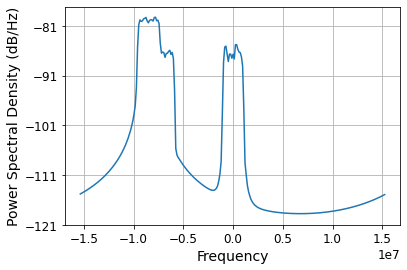

In [28]:
## compute OFDM signal and plot PSD
sig = OFDM_TX(Slot_active, N_FFT, N_CP)

_, _ =plt.psd(sig, Fs=Fs)

## The Complete Received Signal

The received signal contains multiple slots like the one describe above. The samples for each slot are concatenated to form the entire transmitted signal.

Each slot contains the components described in detail above:
1. The synchronization reference signal is always in symbol 0 in the center of the band.
2. Up to $N=10$ DCI blocks are located in symbol 1. The arrangement of DCI blocks varies from slot-to-slot. The DCI block for a given user can be identified via the user id that is embedded in the DCI block. A user has to search DCI blocks until it finds its DCI information.
3. Up to $N=10$ payload segments are placed in rectangular regions that are indicated by the DCI information. There is a one-to-one correspondence between DCI blocks and payloads.

The payloads from consecutive slots form a message that should be recovered. The entire received signal contains messages for $N=10$ users. 

**Hint:** Each slot will contain a payload for all users unless the transmission to a given user is complete. Once a slot does not contain a payload (and DCI block) for a given user, all following slots will not contain a payload for that user either.

**Hint:** The first four bytes of the message contain two 16-bit integers that indicate the length of the entire message in bytes. If you want to know how many bytes your message contains, you can extract that information from the first four received bytes as follows:

``` Python
# assume that `msg` contains the bytes received in the first slot
h, w = struct.unpack('!HH', msg[:4])
# length of message is product of `h` and `w` plus 4
msg_len = h*w + 4
```

## Channel

Channel introduces:
* delay: the signal does not start at a symbol or slot boundary; samples start in the middle of a symbol. Similarly, the received signal does not end on a symbol or slot boundary.
* time-varying frequency offset: the frequency error is slowly time-varying; the largest instantaneous frequency error is approximately 3KHz.
* dispersive channel: the channel is (mildly) dispersive; the magnitude of the channel response should be good enough to receover signals with very low error rate
* AWGN: the nominal SNR is 20dB; however, that varies slightly between subcarriers due to unequal frequency responses.

Your receiver must be able to mitigate the adverse channel effects, including location of slot and symbol boundaries, compensation of frequency error, and frequency domain equalization.

## Load the received signal

That's it. Now it's time to load the received samples and for you to demodulate them.

You can check that you received all parts of the message by lookin at the sequence numbers. Additionally, you can compute the number of bytes in your message by interpreting the first four bytes as explained earlier.

The received messages represent different grayscale images that you can display with the command:
``` Python
bytes_to_img(msg)
```
where `msg` is the byte sequence that you recovered, including the four bytes that specify image dimensions.

Ok, here is the command to load the samples. The variable `rr` holds the entire sequence of samples - all 13,580,387 of them.

In [29]:
import requests
import io
#https://www.dropbox.com/s/thwmobsva2zpr5s/ofdm_samples.npy?dl=0
response = requests.get('https://www.dropbox.com/s/thwmobsva2zpr5s/ofdm_samples.npy?dl=1')
response.raise_for_status()
rr = np.load(io.BytesIO(response.content), allow_pickle=True) 


If all worked well, you can compute the PSD of the received signal and it should look like this.

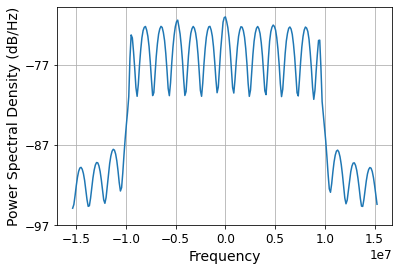

In [30]:
# check the PSD
_, _ = plt.psd(rr, Fs=Fs)

In [31]:
# Here are the first ten samples
rr[:10]

array([ 0.1014309 -0.14270209j, -0.02681683-0.07107736j,
        0.08073202+0.17901753j, -0.0725158 +0.01439013j,
        0.00309469-0.04557215j, -0.00365416-0.07286342j,
       -0.00079192+0.02458342j, -0.02353382+0.09217308j,
        0.02192161-0.00212587j, -0.04593048-0.0781991j ])

## Solution

We will extract the information for one of the users specified by the user id set below

In [32]:
## pick a user id
user_ids = [87, 67, 6, 66, 32, 90, 25, 71, 13, 21]
user_id = user_ids[0]

# since it will be used in multiple places, let's also get the DMRS sequence for this user id
dmrs = make_DMRS(user_id, N_active)

### Synchronization

The first task is to find the beginning of the slot. 

For that purpose, we construct the time-domain reference sequence and correlate it agains the received signal.

In [33]:
## construct synch sequence in the freq domain
sync_active = np.zeros(N_active, dtype=complex)
sync_active[k_sync:k_sync+len(sync_seq)] = sync_seq

N_guard = (N_FFT - N_active) // 2
sync_symbol = np.zeros(N_FFT, dtype=complex)
sync_symbol[N_guard:N_guard+N_active] = sync_active

## transform to time domain
sync_sig = np.fft.ifft(np.fft.fftshift(sync_symbol)) * np.sqrt(N_FFT)

sync_sig = np.concatenate((sync_sig[-N_CP:], sync_sig))



This is cheating a little bit: we are searching for the synch signal only over the first 6000 samples. A better solution would be to perform sequential detection and look for the correlation to exceed a threshold (like 0.8).

In [34]:
## correlate the first 6000 samples against the sync signal
N_sync = 6000
sync_corr = np.zeros(N_sync)
sync_norm = np.linalg.norm(sync_sig)

for n in range(N_sync):
    seg = rr[n:n+N_FFT+N_CP]
    corr = np.sum(seg * sync_sig.conj())
    sync_corr[n] = np.abs(corr) / sync_norm / np.linalg.norm(seg)

Let's see what we found

found first slot at: 5002


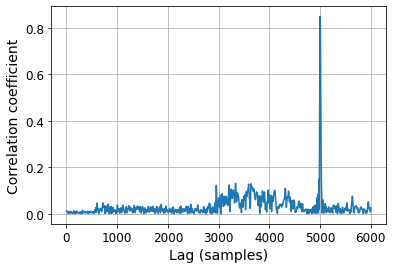

In [35]:
slot_start = np.argmax(sync_corr)
print("found first slot at: {:d}".format(slot_start))

plt.plot(sync_corr)
plt.grid()
plt.xlabel('Lag (samples)')
plt.ylabel('Correlation coefficient')

plt.show()

We now know where the first slot starts. From there we can figure out where all subsequent slots start and where the symbols in each slot start as well.

Let's process the first slot. We begin by collecting all samples within the slot.

In [36]:
## For reasons that aren't entirely clear, we must start with sample 5000 (not 5002) to get successful modulation
slot_start = 5000
slot_sig = rr[slot_start : slot_start + N_syms * (N_FFT + N_CP)]

### Frequency Correction and S/P conversion
Before we can compute the FFT and convert the signal to the frequency domain, we must corect the frequency error. We proceed as follows:
1. estimate the frequency error using the cyclic prefix for each symbol
2. perform frequency correction; this must be phase-continuous
3. strip the cyclic prefix
4. serial-to-parallel conversion (insert samples in a matrix)

In [37]:
slot_sym = np.zeros((N_syms, N_FFT), dtype=complex)
N = N_FFT + N_CP
init_phase = 0

for n in range(N_syms):
    seg = slot_sig[n*N : (n+1)*N]
    # measure (normalized by Fs) frequency offset
    df = np.angle(np.sum(seg[-N_CP:] * np.conj(seg[:N_CP]))) / (2*np.pi*N_FFT)
    # correct frequency offset; phase-continuous
    seg = seg * np.exp(-1j*(init_phase + 2*np.pi*df*np.arange(N)))
    init_phase += 2*np.pi*df*N
    # strip cyclic prefix and insert in Slot matrix
    slot_sym[n,:] = seg[N_CP:]

### FFT
We are now ready to compute the FFT of the samples in the slot. Immediately after FFT, the guard bands are removed.

In [38]:
Slot_rx_active = np.zeros((N_syms, N_active), dtype=complex)

for n in range(N_syms):
    Sym = np.fft.fftshift(np.fft.fft(slot_sym[n,:])) / np.sqrt(N_FFT)
    Slot_rx_active[n, :] = Sym[N_guard : N_guard+N_active]

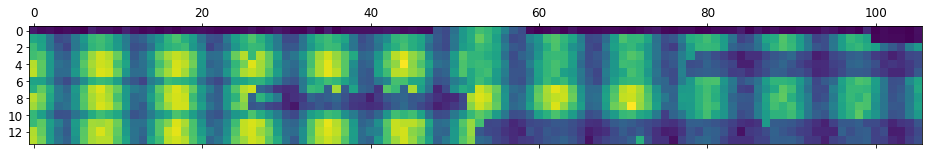

In [39]:
## Does this look reasonable? yes, that's plausible
plt.matshow(np.abs(Slot_rx_active[:,::12]))
plt.show()

### Extract DCI information

DCI information is in the second symbol (symbol 1). However, the DCI for our user id could be in any of ten locations. We will try them all and see which one is for the given user id.

Processing proceeds as follows:
1. get the symbol holding DCI
2. For each of the ten possible locations:
 * collect the 120 subcarriers for the DCI block
 * get channel estimates from the DMRS elements
 * equalize the data locations using the channel estimates
 * apply the MPE decision rule to data
 * decode the DCI block
 * check the CRC and then the user id in the block
 * retain the DCI info for our user id

For equalization, we take advantage of the fact that DMRS elements are closely spaced (on every third subcarrier). Every data symbol is adjacent to a DMRS symbol. For equalization, we will use the channel estimate for the directly adjacent DMRS symbol.


In [40]:
## get the symbol holding the DCI
dci_sym = np.copy(Slot_rx_active[1, :]) # copy may not be needed here; just overly cautious

Found_DCI = False

## process each DCI block
for n in range(len(user_ids)):
    dci_data = np.zeros(2*DCI_LEN//3, dtype=np.uint8)
    k0 = n * DCI_LEN
    dci_block = dci_sym[k0:k0+DCI_LEN]
    # we leave the channel estimates in the dci_block; estimates are formed by 
    # multiplying subcarriers with DMRS data by the DMRS sequence. DMRS data are
    # on every 3rd subcarrier starting with subcarrier 1. (conj is not really needed for BPSK DMRS)
    dci_block[1::3] = dci_block[1::3] * dmrs[k0+1 : k0+DCI_LEN : 3].conj()

    # loop over DCI block
    k = 0
    for m in range(DCI_LEN):
        # equalize
        if (m % 3) == 0:
            # DMRS is to the right
            eq = dci_block[m] / dci_block[m+1]
        elif (m % 3) == 2:
            # DMRS is to the left
            eq = dci_block[m] / dci_block[m-1]

        # if this is not a DMRS subcarrier, demodulate
        if (m % 3) != 1:
            dci_data[k] = 0 if np.real(eq) > 0 else 1
            k += 1

    # done demodulating, try to decode the DCI data
    dci_bytes = symbols_to_bytes(dci_data, 1)
    id, sliv_d, mod_code, seq, n_bytes, crc_ok = decode_DCI(dci_bytes)

    if crc_ok and id == user_id:
        Found_DCI = True
        break

if not Found_DCI:
    print("Failed to find a DCI block")
else:
    print("SLIV: ", sliv_d)
    print("mod_code: ", mod_code)
    print("sequence number: ", seq)
    print("number of bytes:", n_bytes)


SLIV:  {'start_sym': 2, 'len_sym': 4, 'start_scb': 0, 'len_scb': 26}
mod_code:  2
sequence number:  0
number of bytes: 468


### Extracting the payload

From the DCI, we know where the payload is (via `sliv_d`) and how it is modulated (via `mod_code`). We alo know how many bytes the payload contains (from `n_bytes`). That allows us to extract the payload bytes.

The process is as follows:
1. extract the rectangular region indicated by `sliv_d`
2. use the first symbol and the DMRS to form channel estimates
3. for the remaining symbols:
 * perform equalization
 * make symbol decisions
 * convert to bytes

In [41]:
## extract the region that holds the payload
n0 = sliv_d['start_sym']
ls = sliv_d['len_sym']
k0 = sliv_d['start_scb'] * sc_per_scb
lc = sliv_d['len_scb'] * sc_per_scb
pld_region = Slot_rx_active[n0:n0+ls, k0:k0+lc]

## for channel estimates
eq = pld_region[0,:] * dmrs[k0:k0+lc].conj()

## equalize
eq_pld = np.zeros((ls-1)*lc, dtype=complex)
for n in range(1, ls):
    eq_pld[(n-1)*lc:n*lc] = pld_region[n, :] / eq

## MPE decision rule
# first figure out pld is modulated
mod_type = rev_mod_table[mod_code]
bps = mod_table[mod_type]['bps']
A = mod_table[mod_type]['alphabet']
# we will need this many symbols
Ns = n_bytes * 8 // bps
# then demodulate
pld_syms = MPE_decision_rule(eq_pld[:Ns], A)

pld_bytes = symbols_to_bytes(pld_syms, bps)

We can perform two checks to see if this was successful:
1. the majority of bytes in the first slot should be zero
2. the first four bytes represent two numbers that should be approximately 300

In [42]:
n_zeros = np.sum(pld_bytes == 0)
w = pld_bytes[0]*256 + pld_bytes[1]
h = pld_bytes[2]*256 + pld_bytes[3]

print("Found {:d} zeros in {:d} bytes".format(n_zeros, n_bytes))
print("The two integers are w={:d} and h={:d}".format(w, h))

Found 451 zeros in 468 bytes
The two integers are w=320 and h=480


## Recovering the entire message

It looks like this worked. Now, all we have to do is repeat the above procedure for the remaining slots. To make this task more modular, we wrap some of the above funcionality in functions

### Frequency Correction and S/P Conversion

In [43]:
def freq_correct(slot_sig, N_FFT, N_CP, N_syms):
    """frequency correction and S/P conversion
    
    Inputs:
    slot_sig - samples for a given slot
    N_FFT - FFT length
    N_CP - length of cyclic prefix
    N_syms - number of symbols per slot

    Returns:
    2D matrix of frequency corrected samples with CP removed
    """
    slot_sym = np.zeros((N_syms, N_FFT), dtype=complex)
    N = N_FFT + N_CP
    init_phase = 0

    for n in range(N_syms):
        seg = slot_sig[n*N : (n+1)*N]
        # measure (normalized by Fs) frequency offset
        df = np.angle(np.sum(seg[-N_CP:] * np.conj(seg[:N_CP]))) / (2*np.pi*N_FFT)
        # correct frequency offset; phase-continuous
        seg = seg * np.exp(-1j*(init_phase + 2*np.pi*df*np.arange(N)))
        init_phase += 2*np.pi*df*N
        # strip cyclic prefix and insert in Slot matrix
        slot_sym[n,:] = seg[N_CP:]

    return slot_sym

### FFT

In [44]:
def OFDM_FFT(slot_sym, N_FFT, N_guard):
    """OFDM FFT
    
    Inputs:
    slot_sym - 2D matrix of time-domain samples (without CP)
    N_FFT - FFT length
    N_guard - number of guard bands on either side of active subcarriers

    Returns:
    2D matrix of frequency domain samples; active subcarriers only
    """
    Slot_rx_active = np.zeros((N_syms, N_active), dtype=complex)

    for n in range(N_syms):
        Sym = np.fft.fftshift(np.fft.fft(slot_sym[n,:])) / np.sqrt(N_FFT)
        Slot_rx_active[n, :] = Sym[N_guard : N_guard+N_active]

    return Slot_rx_active

### Get DCI

In [45]:
def get_DCI(dci_sym, dmrs, user_id, n_dci, DCI_LEN):

    Found_DCI = False

    ## process each DCI block
    for n in range(n_dci):
        dci_data = np.zeros(2*DCI_LEN//3, dtype=np.uint8)
        k0 = n * DCI_LEN
        dci_block = dci_sym[k0:k0+DCI_LEN]
        # we leave the channel estimates in the dci_block; estimates are formed by 
        # multiplying subcarriers with DMRS data by the DMRS sequence. DMRS data are
        # on every 3rd subcarrier starting with subcarrier 1. (conj is not really needed for BPSK DMRS)
        dci_block[1::3] = dci_block[1::3] * dmrs[k0+1 : k0+DCI_LEN : 3].conj()

        # loop over DCI block
        k = 0
        for m in range(DCI_LEN):
            # equalize
            if (m % 3) == 0:
                # DMRS is to the right
                eq = dci_block[m] / dci_block[m+1]
            elif (m % 3) == 2:
                # DMRS is to the left
                eq = dci_block[m] / dci_block[m-1]

            # if this is not a DMRS subcarrier, demodulate
            if (m % 3) != 1:
                dci_data[k] = 0 if np.real(eq) > 0 else 1
                k += 1

        # done demodulating, try to decode the DCI data
        dci_bytes = symbols_to_bytes(dci_data, 1)
        id, sliv_d, mod_code, seq, n_bytes, crc_ok = decode_DCI(dci_bytes)

        if crc_ok and id == user_id:
            Found_DCI = True
            break

    if not Found_DCI:
        # print("Failed to find a DCI block")

        return None, None, None, None
    else:
        # print("SLIV: ", sliv_d)
        # print("mod_code: ", mod_code)
        # print("sequence number: ", seq)
        # print("number of bytes:", n_bytes)

        return sliv_d, mod_code, n_bytes, seq

### Extract Payload

In [46]:
def extract_payload(Slot_rx_active, dmrs, sliv_d, mod_code, n_bytes, sc_per_scb=12):
    
    ## extract the region that holds the payload
    n0 = sliv_d['start_sym']
    ls = sliv_d['len_sym']
    k0 = sliv_d['start_scb'] * sc_per_scb
    lc = sliv_d['len_scb'] * sc_per_scb
    pld_region = Slot_rx_active[n0:n0+ls, k0:k0+lc]

    ## for channel estimates
    eq = pld_region[0,:] * dmrs[k0:k0+lc].conj()

    ## equalize
    eq_pld = np.zeros((ls-1)*lc, dtype=complex)
    for n in range(1, ls):
        eq_pld[(n-1)*lc:n*lc] = pld_region[n, :] / eq

    ## MPE decision rule
    # first figure out pld is modulated
    mod_type = rev_mod_table[mod_code]
    bps = mod_table[mod_type]['bps']
    A = mod_table[mod_type]['alphabet']
    # we will need this many symbols
    Ns = n_bytes * 8 // bps
    # then demodulate
    pld_syms = MPE_decision_rule(eq_pld[:Ns], A)

    pld_bytes = symbols_to_bytes(pld_syms, bps)

    return pld_bytes

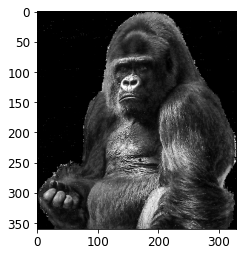

In [47]:
# pick a user_id and compute associated DMRS
user_id = user_ids[1]  # <--- set index to number in range(10)
dmrs = make_DMRS(user_id, N_active)

DONE = False

n_msg = 0
n_slot = 0
first_slot_start = 5000

while not DONE:
    # get samples for current slot
    slot_start = first_slot_start + n_slot * N_syms * (N_FFT + N_CP)
    slot_sig = rr[slot_start : slot_start + N_syms * (N_FFT + N_CP)]

    slot_sym = freq_correct(slot_sig, N_FFT, N_CP, N_syms)
    Slot_rx_active = OFDM_FFT(slot_sym, N_FFT, N_guard)

    sliv_d, mod_code, n_bytes, seq = get_DCI(Slot_rx_active[1,:], dmrs, user_id, len(user_ids), DCI_LEN)


    if sliv_d is not None:
        pld_bytes = extract_payload(Slot_rx_active, dmrs, sliv_d, mod_code, n_bytes)
        if n_slot == 0:
            w = pld_bytes[0]*256 + pld_bytes[1]
            h = pld_bytes[2]*256 + pld_bytes[3]
            msg = np.zeros(h*w + 4, dtype=np.uint8)

        msg[n_msg:n_msg+n_bytes] = pld_bytes
        n_msg += n_bytes
    
    n_slot += 1

    if slot_start + 2 * N_syms * (N_FFT + N_CP) > len(rr):
        DONE = True

bytes_to_img(msg)